# Import library

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU

# Import dataset

In [4]:
 # EUR - VND
eur = pd.read_csv('EUR.csv')
 # GBP - VND
gbp = pd.read_csv("GBP.csv")
 # JPY - VND
jpy = pd.read_csv("JPY.csv")
# Convert
eur = eur['Sale'].replace({',':''}, regex=True).astype(float)
gbp = gbp['Sale'].replace({',':''}, regex=True).astype(float)
jpy = jpy['Sale'].replace({',':''}, regex=True).astype(float)

# Split train, test

In [5]:
#### EUR - VND
  # case 1. 7:3
train_eur_1 = eur[:int(0.7*len(eur))]
test_eur_1 = eur[int(0.7*len(eur)):]
  # case 2. 8:2
train_eur_2 = eur[:int(0.8*len(eur))]
test_eur_2 = eur[int(0.8*len(eur)):]
  # case 3. 9:1
train_eur_3 = eur[:int(0.9*len(eur))]
test_eur_3 = eur[int(0.9*len(eur)):]

#### GBP - VND
  # case 1. 7:3
train_gbp_1 = gbp[:int(0.7*len(gbp))]
test_gbp_1 = gbp[int(0.7*len(gbp)):]
  # case 2. 8:2
train_gbp_2 = gbp[:int(0.8*len(gbp))]
test_gbp_2 = gbp[int(0.8*len(gbp)):]
  # case 3. 9:1
train_gbp_3 = gbp[:int(0.9*len(gbp))]
test_gbp_3 = gbp[int(0.9*len(gbp)):]

#### JPY - VND
  # case 1. 7:3
train_jpy_1 = jpy[:int(0.7*len(jpy))]
test_jpy_1 = jpy[int(0.7*len(jpy)):]
  # case 2. 8:2
train_jpy_2 = jpy[:int(0.8*len(jpy))]
test_jpy_2 = jpy[int(0.8*len(jpy)):]
  # case 3. 9:1
train_jpy_3 = jpy[:int(0.9*len(jpy))]
test_jpy_3 = jpy[int(0.9*len(jpy)):]

# Scale data

In [6]:
scaler=MinMaxScaler(feature_range=(0,1))

# Functions

In [7]:
def standardizate_data(train, test, pre_test, f30, f60, f90):
  train = np.reshape(train, (-1,1))
  train1 = scaler.inverse_transform(train)

  test = np.reshape(test, (-1,1))
  test1 = scaler.inverse_transform(test)

  pre_test = np.reshape(pre_test, (-1,1))
  pre_test1 = scaler.inverse_transform(pre_test)

  f30 = np.reshape(f30, (-1,1))
  f30_1 = scaler.inverse_transform(f30)
   
  f60 = np.reshape(f60, (-1,1))
  f60_1 = scaler.inverse_transform(f60)
  
  f90 = np.reshape(f90, (-1,1))
  f90_1 = scaler.inverse_transform(f90)
    
  return train1, test1, pre_test1, f30_1, f60_1, f90_1

In [8]:
# Model accuracy evaluation function
def accuracy(forecast, actual):
    forecast = np.array(forecast)
    actual = np.array(actual)
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))*100  # MAPE
    mae = np.mean(np.abs(forecast - actual))    # MAE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE

    print('RMSE =',rmse)
    print('MAPE =',mape)
    print('MAE =',mae)

In [9]:
# Function to convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

# Function to convert data
def convert_data(train, test, time_step):
    # Reshape into X = t, t+1, t+2 ,..., t+99 and Y = t+100
    X_train, y_train = create_dataset(train, time_step)
    X_test, y_test = create_dataset(test, time_step)
    # Reshape input to be [samples, time steps, features] which is required for LSTM
    X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)  # => 3D
    X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
    return X_train, y_train, X_test, y_test

# GRU (Gated Recurrent Units)


In [10]:
# Hàm dự báo 30 ngày tiếp theo
def forecast_days(model, test):
  x_input = test[len(test)-100:].reshape(1,-1)

  temp_input=list(x_input)
  temp_input=temp_input[0].tolist()

  f30=[]
  f60=[]
  f90=[]
  n_steps=100
  i=0
  while(i<=90):
      if(len(temp_input)>100):
          x_input=np.array(temp_input[1:])
          print("{} day input {}".format(i,x_input))
          x_input = x_input.reshape(1,-1)
          x_input = x_input.reshape((1, n_steps, 1)) #3D
          yhat = model.predict(x_input, verbose=0)
          print("{} day output {}".format(i,yhat))
          temp_input.extend(yhat[0].tolist())
          temp_input=temp_input[1:]
          if i <= 30:
            f30.extend(yhat.tolist())
          elif i <= 60:
            f60.extend(yhat.tolist())
          else:
            f90.extend(yhat.tolist())
          i=i+1
      else:
          x_input = x_input.reshape((1, n_steps, 1))
          yhat = model.predict(x_input, verbose=0)
          print(yhat[0])
          temp_input.extend(yhat[0].tolist())
          print(len(temp_input))
          f30.extend(yhat.tolist())
          i=i+1
  return f30, f60, f90

In [11]:
# Hàm trực quan hóa model
def visualize_GRU(model, train, test, pre_test, f30, f60, f90):
    start_date = pd.to_datetime('3/1/2019')
    end_date_fc = pd.to_datetime('9/1/2024')

    index = pd.date_range(start=start_date, end=end_date_fc, freq='D')
    
    unique_years = index.year.unique()
    x_ticks = [pd.to_datetime(str(year)) for year in unique_years]
    
    plt.xticks(x_ticks, unique_years)    

    train_index = index[:len(train)]
    test_index = index[len(train): len(train) + len(test)]
    pre_test_index = index[len(train) + 101: len(train) + len(test)]

    f30_index = index[len(train) + len(test) - 1: len(train) + len(test) + 30]
    f60_index = index[len(train) + len(test) + 30: len(train) + len(test) + 60]
    f90_index = index[len(train) + len(test) + 60: len(train) + len(test) + 90]
    
    # Visualize
    plt.plot(train_index, scaler.inverse_transform(train))
    plt.plot(test_index, scaler.inverse_transform(test))
    plt.plot(pre_test_index,scaler.inverse_transform(pre_test))
    
    plt.plot(f30_index, scaler.inverse_transform(f30))
    plt.plot(f60_index, scaler.inverse_transform(f60))
    plt.plot(f90_index, scaler.inverse_transform(f90))
    
    plt.title('GRU Time Series Forecast')
    plt.xlabel('Date')
    plt.ylabel('Exchange Rate (VND)')
    plt.legend(['Train','Test','PredictedTest','ForecastNext30Days','ForecastNext60Days','ForecastNext90Days'])
    plt.show()

In [12]:
def implementGRU(train, test):
  time_step = 100
  X_train, y_train, X_test, y_test = convert_data(train, test, time_step)

  # Define GRU Model
  model = Sequential()
  model.add(GRU(64, input_shape=(time_step, 1)))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mean_squared_error')

  # Fit model
  model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1)
  pre_test = model.predict(X_test)
  f30, f60, f90 = forecast_days(model, test)
  visualize_GRU(model, train, test, pre_test, f30, f60, f90)
  train, test, pre_test, f30, f60, f90 = standardizate_data(train, test, pre_test, f30, f60, f90)

  test1 = test[101:]
  print('- Model accuracy evaluation: ')
  accuracy(pre_test, test1)

**EUR_VND**

In [13]:
#### EUR - VND
eur_sc = scaler.fit_transform(np.array(eur).reshape(-1,1))
# case 1. 7:3
train_eur_1_sc = eur_sc[:int(0.7*len(eur))]
test_eur_1_sc = eur_sc[int(0.7*len(eur)):]
# case 2. 8:2
train_eur_2_sc = eur_sc[:int(0.8*len(eur))]
test_eur_2_sc = eur_sc[int(0.8*len(eur)):]
# case 3. 9:1
train_eur_3_sc = eur_sc[:int(0.9*len(eur))]
test_eur_3_sc = eur_sc[int(0.9*len(eur)):]

* Case 7:3

==== GRU model - EUR (7:3) ====


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 0.1929 - val_loss: 0.0212
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0142 - val_loss: 0.0039
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0058 - val_loss: 0.0013
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0034 - val_loss: 9.5262e-04
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0024 - val_loss: 6.9104e-04
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0014 - val_loss: 5.3096e-04
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 9.8814e-04 - val_loss: 4.7792e-04
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 7.1242e-04 - val_loss: 4.7820e-04
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 7.0608e-04 - val_loss: 4.6319e-04
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 6.9696e-04 - val_loss: 4.3531e-04
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 7.1441e-04 - val_loss: 4.4942e-04


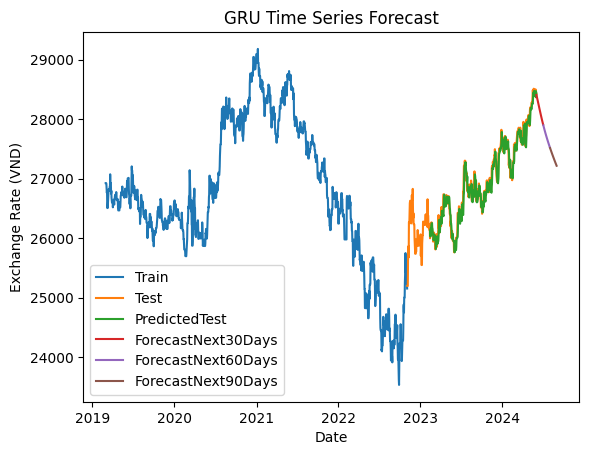

- Model accuracy evaluation: 
RMSE = 126.17700659842528
MAPE = 0.35100588778594094
MAE = 94.60147615131602


In [14]:
print("==== GRU model - EUR (7:3) ====")
implementGRU(train_eur_1_sc, test_eur_1_sc)

* Case 8:2

==== GRU model - EUR (8:2) ====
Epoch 1/100


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 0.0744 - val_loss: 0.0016
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0042 - val_loss: 6.7135e-04
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0021 - val_loss: 5.6456e-04
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.0013 - val_loss: 5.3192e-04
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 8.5567e-04 - val_loss: 4.3258e-04
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 6.7407e-04 - val_loss: 3.5108e-04
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 6.5814e-04 - val_loss: 3.3022e-04
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 6.1080e-04 - val_loss: 3.3177e-04
Epoch 9/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 5.8830e-04 - val_loss: 3.2096e-04
Epoch 10/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 5.9168e-04 - val_loss: 3.1036e-04
Epoch 11/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - loss: 5.6957e-04 - val_loss: 3.0670e

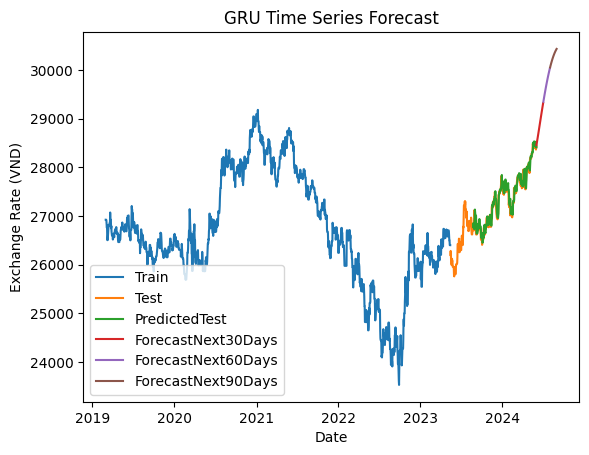

- Model accuracy evaluation: 
RMSE = 118.82882516249477
MAPE = 0.3256889778133028
MAE = 88.98590023189047


In [15]:
print("==== GRU model - EUR (8:2) ====")
implementGRU(train_eur_2_sc, test_eur_2_sc)

* Case 9:1

==== GRU model - EUR (9:1) ====
Epoch 1/100


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - loss: 0.1419 - val_loss: 6.7037e-04
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 0.0057 - val_loss: 0.0017
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - loss: 0.0035 - val_loss: 0.0029
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0022 - val_loss: 0.0017
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 0.0013 - val_loss: 7.9617e-04
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 8.2155e-04 - val_loss: 4.6254e-04
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 6.9381e-04 - val_loss: 3.4123e-04
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 6.6608e-04 - val_loss: 3.3191e-04
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 6.6329e-04 - val_loss: 3.3068e-04
Epoch 10/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - loss: 6.1132e-04 - val_loss: 3.3636e-04
Epoch 11/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - loss: 6.0737e-04 - val_loss: 2.9576e-04
Epoch 1

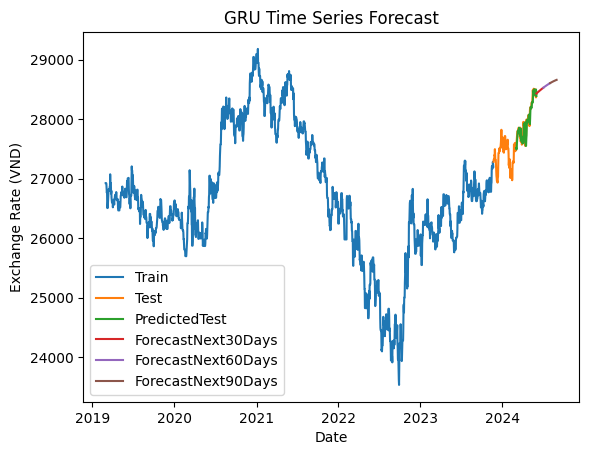

- Model accuracy evaluation: 
RMSE = 109.45095852718762
MAPE = 0.2795980934577545
MAE = 78.05840058379137


In [16]:
print("==== GRU model - EUR (9:1) ====")
implementGRU(train_eur_3_sc, test_eur_3_sc)

**JPY_VND**

In [17]:
#### JPY - VND
jpy_sc = scaler.fit_transform(np.array(jpy).reshape(-1,1))
  # case 1. 7:3
train_jpy_1_sc = jpy_sc[:int(0.7*len(jpy))]
test_jpy_1_sc = jpy_sc[int(0.7*len(jpy)):]
  # case 2. 8:2
train_jpy_2_sc = jpy_sc[:int(0.8*len(jpy))]
test_jpy_2_sc = jpy_sc[int(0.8*len(jpy)):]
  # case 3. 9:1
train_jpy_3_sc = jpy_sc[:int(0.9*len(jpy))]
test_jpy_3_sc = jpy_sc[int(0.9*len(jpy)):]

* Case 7:3

==== GRU model - JPY (7:3) ====
Epoch 1/100


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.5433 - val_loss: 0.0889
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0282 - val_loss: 0.0531
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0133 - val_loss: 0.0577
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0090 - val_loss: 0.0378
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0066 - val_loss: 0.0278
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0045 - val_loss: 0.0168
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0031 - val_loss: 0.0090
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0017 - val_loss: 0.0043
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 9.0123e-04 - val_loss: 0.0020
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 6.6682e-04 - val_loss: 8.7518e-04
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 6.0691e-04 - val_loss: 5.7357e-04
Epoch 12/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 3

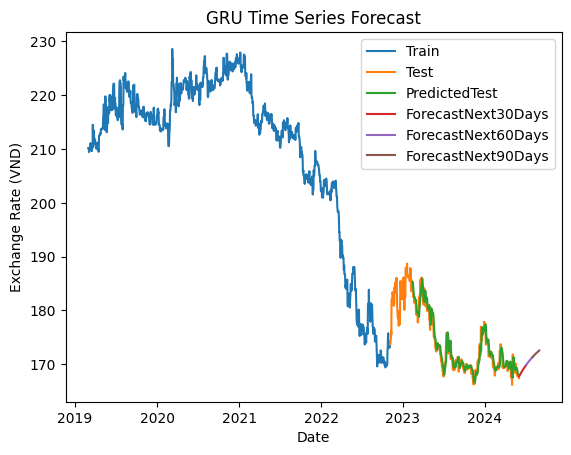

- Model accuracy evaluation: 
RMSE = 1.2865130916668834
MAPE = 0.5499787686561896
MAE = 0.9549516280324839


In [18]:
print("==== GRU model - JPY (7:3) ====")
implementGRU(train_jpy_1_sc, test_jpy_1_sc)

* Case 8:2

==== GRU model - JPY (8:2) ====
Epoch 1/100


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.2499 - val_loss: 0.0655
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0152 - val_loss: 0.0229
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0058 - val_loss: 0.0158
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0033 - val_loss: 0.0078
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0017 - val_loss: 0.0029
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 8.4441e-04 - val_loss: 9.2892e-04
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 5.8094e-04 - val_loss: 3.8656e-04
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 5.2221e-04 - val_loss: 2.8488e-04
Epoch 9/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 4.5939e-04 - val_loss: 2.6869e-04
Epoch 10/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 5.5406e-04 - val_loss: 2.6959e-04
Epoch 11/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 4.5794e-04 - val_loss: 2.6305e-04
Epoch 12/100
23/

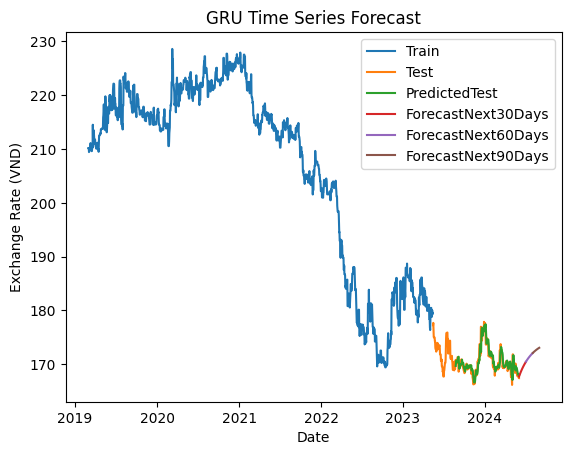

- Model accuracy evaluation: 
RMSE = 1.050189283684668
MAPE = 0.4258564088233125
MAE = 0.7276330544839064


In [19]:
print("==== GRU model - JPY (8:2) ====")
implementGRU(train_jpy_2_sc, test_jpy_2_sc)

* Case 9:1

==== GRU model - JPY (9:1) ====
Epoch 1/100


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.3458 - val_loss: 0.0927
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0219 - val_loss: 0.0278
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0074 - val_loss: 0.0082
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0022 - val_loss: 0.0010
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 6.6053e-04 - val_loss: 3.4415e-04
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 5.3976e-04 - val_loss: 3.3521e-04
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 5.3944e-04 - val_loss: 3.3926e-04
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 5.1909e-04 - val_loss: 3.3267e-04
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 5.5860e-04 - val_loss: 3.3421e-04
Epoch 10/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 5.1275e-04 - val_loss: 3.3323e-04
Epoch 11/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 4.7700e-04 - val_loss: 3.1928e-04
Epoch 12

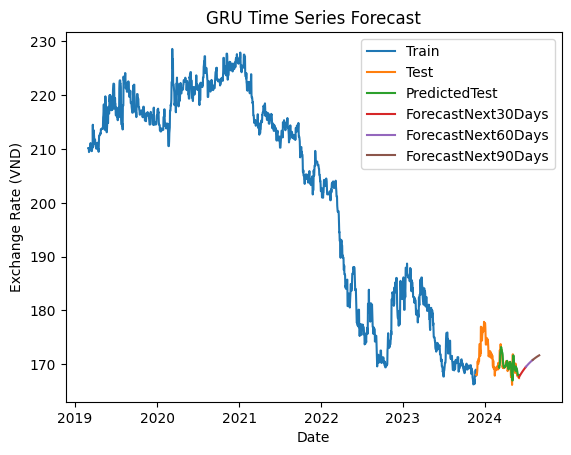

- Model accuracy evaluation: 
RMSE = 1.1057034488177282
MAPE = 0.45849214753989076
MAE = 0.7792499114654876


In [20]:
print("==== GRU model - JPY (9:1) ====")
implementGRU(train_jpy_3_sc, test_jpy_3_sc)

**GBP_VND**

In [21]:
#### GBP - VND
gbp_sc = scaler.fit_transform(np.array(gbp).reshape(-1,1))
  # case 1. 7:3
train_gbp_1_sc = gbp_sc[:int(0.7*len(gbp))]
test_gbp_1_sc = gbp_sc[int(0.7*len(gbp)):]
  # case 2. 8:2
train_gbp_2_sc = gbp_sc[:int(0.8*len(gbp))]
test_gbp_2_sc = gbp_sc[int(0.8*len(gbp)):]
  # case 3. 9:1
train_gbp_3_sc = gbp_sc[:int(0.9*len(gbp))]
test_gbp_3_sc = gbp_sc[int(0.9*len(gbp)):]

* Case 7:3

==== GRU model - GBP (7:3) ====
Epoch 1/100


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.2356 - val_loss: 0.0242
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0165 - val_loss: 0.0079
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0056 - val_loss: 0.0019
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0036 - val_loss: 0.0018
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0029 - val_loss: 0.0013
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0019 - val_loss: 8.1839e-04
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0015 - val_loss: 6.4731e-04
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0012 - val_loss: 5.5447e-04
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0010 - val_loss: 4.5218e-04
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 9.6984e-04 - val_loss: 3.9567e-04
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 9.6135e-04 - val_loss: 3.7532e-04
Epoch 12/100
20/20 ━━━━━━━━━━━━━

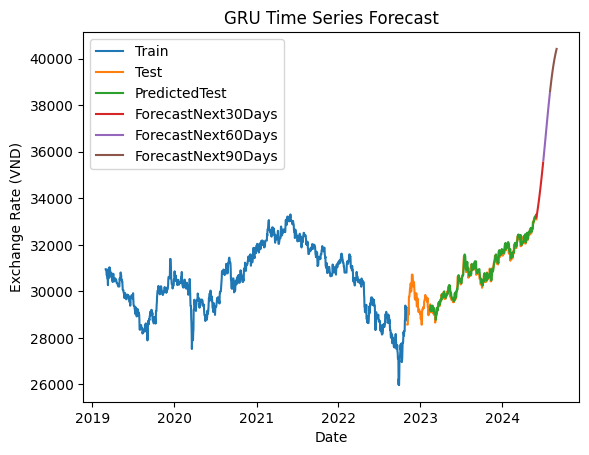

- Model accuracy evaluation: 
RMSE = 160.72397070353375
MAPE = 0.40507728451024394
MAE = 125.14136924342105


In [22]:
print("==== GRU model - GBP (7:3) ====")
implementGRU(train_gbp_1_sc, test_gbp_1_sc)

* Case 8:2

==== GRU model - GBP (8:2) ====


Epoch 1/100


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.1394 - val_loss: 0.0025
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0057 - val_loss: 0.0026
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0034 - val_loss: 0.0028
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0025 - val_loss: 0.0014
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0019 - val_loss: 9.4964e-04
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0012 - val_loss: 5.2679e-04
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 9.9310e-04 - val_loss: 4.5100e-04
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 8.2043e-04 - val_loss: 3.2912e-04
Epoch 9/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 8.2892e-04 - val_loss: 3.2107e-04
Epoch 10/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 7.6478e-04 - val_loss: 3.0389e-04
Epoch 11/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 7.2329e-04 - val_loss: 3.3127e-04
Epoch 12/100
23/

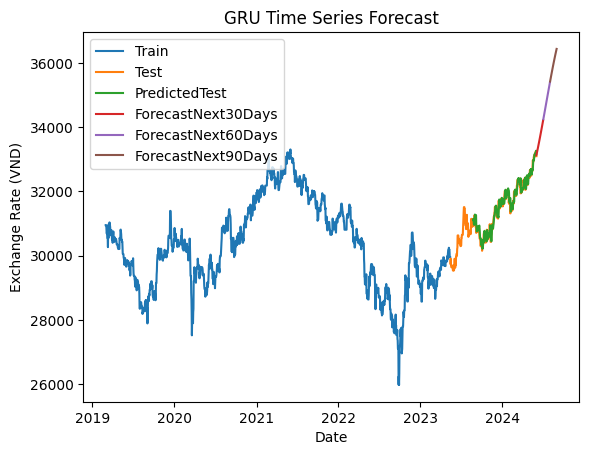

- Model accuracy evaluation: 
RMSE = 150.13049803690376
MAPE = 0.36169974632927987
MAE = 113.95350458259726


In [23]:
print("==== GRU model - GBP (8:2) ====")
implementGRU(train_gbp_2_sc, test_gbp_2_sc)

* Case 9:1

==== GRU model - GBP (9:1) ====
Epoch 1/100


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.2367 - val_loss: 0.0012
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0096 - val_loss: 0.0111
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0049 - val_loss: 0.0095
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0037 - val_loss: 0.0052
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0026 - val_loss: 0.0032
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0018 - val_loss: 0.0013
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0013 - val_loss: 9.8017e-04
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 9.4111e-04 - val_loss: 3.6243e-04
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 8.1789e-04 - val_loss: 4.0264e-04
Epoch 10/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 7.4216e-04 - val_loss: 2.8989e-04
Epoch 11/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 7.3085e-04 - val_loss: 2.8965e-04
Epoch 12/100
26/26 ━━━━━━━━━

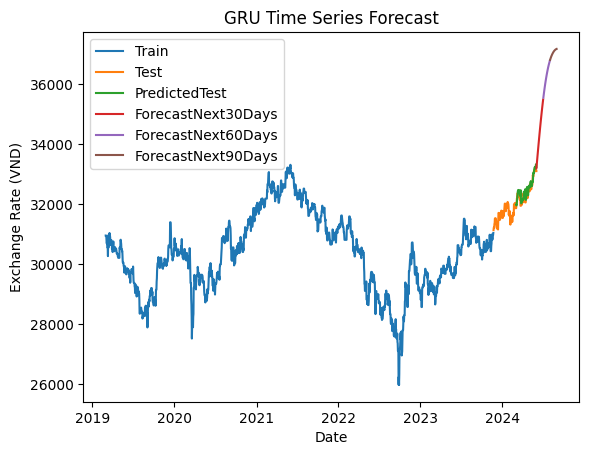

- Model accuracy evaluation: 
RMSE = 152.6850679429903
MAPE = 0.3776393628860779
MAE = 122.26541037087912


In [24]:
print("==== GRU model - GBP (9:1) ====")
implementGRU(train_gbp_3_sc, test_gbp_3_sc)